# Hand Gesture Recogination Convolutional Neural Network
  
Author:       Mansur Amin <br>
Team:         ASL Dynamics <br>
Team Members: Matt Wnuk, Juan Castillo <br>
Class:        ECE 285 Spring 2018 : Machine Learning for Computer Vision <br>

- Build a convolutional neural network with TensorFlow for for gesture recogination using the MNIST ASL Dataset avaiable on Kaggel.

- This project uses TensorFlow layers API for a raw TensorFlow implementation with variables. <br>
Reference: Aymeric Damien's project to recognize digits in images from the MNIST digits dataset <br>
Reference source: https://github.com/aymericdamien/TensorFlow-Examples/ <br>

## CNN Overview

Convolutional Neural network 

![CNN](https://cdn-images-1.medium.com/max/1400/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

## MNIST Dataset Overview

This example is using MNIST ASL Hand Gestures. The dataset contains 27,456 examples for training and 7,173 examples for testing. The images have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST](https://www.kaggle.com/databundle/preview/image-dataset/3258/5337/5337/15172)

More info: https://www.kaggle.com/datamunge/sign-language-mnist/data

In [1]:
####################################################################
# Libraries 
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
#####################################################################
# def read_data(path) :
# Reads data specidfed by path and stores into numpy array, Splits data nad lbl
# path = location of where data is stored
#####################################################################
def read_data(path) :
    num_lines = sum(1 for line in open(path)) # get number of lines in file
    myfile = open(path,'r')
    j = 0
    read_lines = np.zeros((num_lines,785))    # expects a 25x25 pixel row vector
    for line in myfile :
        if(j >= 1) :
            read_lines[j,:] = np.asarray(line.split(','))
        j = j+1
    myfile.close()
    
    print('Initial', path[49:54], 'Shape:', read_lines.shape)
    read_lines = np.delete(read_lines,0,0) # remove pixel labels row from frost row
    labels = read_lines[:,0]
    read_lines = np.delete(read_lines,0,1) # remove labels from first collumn
    print('Augmented', path[49:54], 'Shape:', read_lines.shape)
    return read_lines,labels.astype(np.int16) # .reshape(len(labels),1)

#####################################################################
# def vis_data(dat_vec,dat_lbl) :
# Visualize data.
# dat_vec = vector representing data
# dat_lbl = label representing data
#####################################################################
def vis_data(dat_vec,dat_lbl) :
    lbl_map = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    dat_mat = dat_vec.reshape(28,28)
    plt.title('Image Label = ' + str(dat_lbl) + ' = ' + lbl_map[dat_lbl])
    plt.imshow(dat_mat)
    
#####################################################################
# def normalize_MNIST_images(x) :
# Normalize data in range of -1 to 1
# x = vector representing data
#####################################################################
def normalize_MNIST_images(x,max_x, diff) : 
    x = x.astype(np.float64)
    x = max_x*(x-np.min(x))/(np.max(x)-np.min(x))-diff
    print("Normalize_MNIST_images", x.shape)
    return x

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Initial train Shape: (27456, 785)
Augmented train Shape: (27455, 784)
Initial test. Shape: (7173, 785)
Augmented test. Shape: (7172, 784)
Normalize_MNIST_images (27455, 784)
Normalize_MNIST_images (7172, 784)


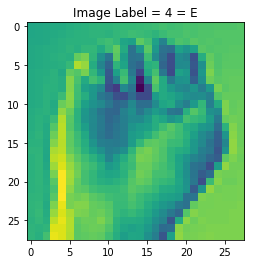

In [2]:
## Read ASL MNIST data
####################################################################
# # Windows Path
# train_path = 'C:\\Users\\maamin\\Desktop\\ECE_285_ML_DL\\data\\sign_mnist_train.csv'
# test_path = 'C:\\Users\\maamin\\Desktop\\ECE_285_ML_DL\\data\\sign_mnist_test.csv'
####################################################################
# # Mac path
# train_path = '/Users/mansuramin/Desktop/ECE_285_ML/data/sign_mnist_train.csv'
# test_path = '/Users/mansuramin/Desktop/ECE_285_ML/data/sign_mnist_test.csv'
####################################################################
# Linux Server Path
train_path = '/datasets/home/56/256/maamin/asl_data/sign_mnist_train.csv'
test_path = '/datasets/home/56/256/maamin/asl_data/sign_mnist_test.csv'
####################################################################
# Load data from path
xtrain,ltrain = read_data(train_path)
xtest,ltest = read_data(test_path)
####################################################################
# Normalize between 0 and 1
xtrain = normalize_MNIST_images(xtrain,1,0)
xtest = normalize_MNIST_images(xtest,1,0)
####################################################################
# Change Types to match nn types
xtrain = xtrain.astype(np.float32)
ltrain = ltrain.astype(np.uint8)
xtest = xtest.astype(np.float32)
ltest = ltest.astype(np.uint8)
####################################################################
# Visualize an image as test
indx = 10240

vis_data(xtrain[indx,:],ltrain[indx])

In [3]:
print(mnist.train.images.shape)

(55000, 784)


In [4]:
#####################################################################
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)
#####################################################################
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

#####################################################################
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()


# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))


Step 1, Minibatch Loss= 72407.8906, Training Accuracy= 0.109
Step 10, Minibatch Loss= 27264.1016, Training Accuracy= 0.242
Step 20, Minibatch Loss= 10460.0596, Training Accuracy= 0.539
Step 30, Minibatch Loss= 6482.0068, Training Accuracy= 0.703
Step 40, Minibatch Loss= 3905.6238, Training Accuracy= 0.812
Step 50, Minibatch Loss= 2389.6243, Training Accuracy= 0.906
Step 60, Minibatch Loss= 3640.3276, Training Accuracy= 0.812
Step 70, Minibatch Loss= 3553.6602, Training Accuracy= 0.859
Step 80, Minibatch Loss= 3361.6553, Training Accuracy= 0.883
Step 90, Minibatch Loss= 1805.4478, Training Accuracy= 0.883
Step 100, Minibatch Loss= 2948.9309, Training Accuracy= 0.836
Step 110, Minibatch Loss= 2379.0520, Training Accuracy= 0.906
Step 120, Minibatch Loss= 3342.1931, Training Accuracy= 0.852
Step 130, Minibatch Loss= 3353.4324, Training Accuracy= 0.875
Step 140, Minibatch Loss= 1690.9668, Training Accuracy= 0.914
Step 150, Minibatch Loss= 895.6429, Training Accuracy= 0.953
Step 160, Minibat

In [28]:
x,y = mnist.train.next_batch(128)

In [29]:
x.shape

(128, 784)

In [30]:
y.shape

(128, 10)

In [18]:
np.round(NB).astype(np.long)

214

In [6]:
xtrain.shape[0]

27455

In [21]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 10

N = xtrain.shape[0]            # training set size 
B = batch_size                  # minibatch size
NB = N / B                      # number of minibatches
NB = np.round(NB).astype(np.long)

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 25 # MNIST total classes (0-25 gestures)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [22]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [23]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [24]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    idxminibathches = np.random.permutation(NB) # shuffling 
    for step in range(1, num_steps+1):
#         batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        ########################
        i = idxminibathches[step] # index of minibatch
        
        # extract i-th minibatch from xtrain and ltrain 
        idxsmp = np.arange(i*B,np.min((i*B+B,N)))          # indicies of samples for i-th minibatch
        
        batch_x = xtrain[idxsmp]
        batch_y = ltrain[idxsmp]
        #################
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))


ValueError: Cannot feed value of shape (128,) for Tensor u'Placeholder_16:0', which has shape '(?, 25)'